<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Transfer_learning/TVshow_characters_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simpsons characters classification

## Install libs

In [1]:
%%capture
!pip install kaggle wandb requests beautifulsoup4

## imports

In [2]:
import io
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import random
import requests
import seaborn as sns
import os
import torch
import torch.nn as nn
import wandb

from bs4 import BeautifulSoup
from google.colab import files
from matplotlib.font_manager import FontProperties
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from torch.optim import Adam, AdamW, lr_scheduler
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from tqdm import tqdm, tqdm_notebook
from urllib.parse import quote_plus
from IPython.display import display


### Create folder and download the dataset

If you want to follow this track, don't forget to put **your** kaggle API (download kaggle.json from kaggle.com) in the current dirrectory (I assume its 'content' for you)

In [9]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c journey-springfield
!unzip -q journey-springfield.zip

 99% 518M/521M [00:04<00:00, 166MB/s]
100% 521M/521M [00:04<00:00, 133MB/s]


If you cannot perform the actions above or you don't have kaggle account (what are you doing here then?) - uncomment and use the code below. Of course you need to mount the drive and upload your version of dataset

In [4]:
#from google.colab import drive
#drive.mount('/content/gdrive/')
#!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

## Get more data

In [10]:
def get_more_images(name, num, start=0):
  search_query = name.replace('_', ' ').title() + ' simpsons character pictures'
  encoded_query = quote_plus(search_query)

  url = f"https://www.google.com/search?q={encoded_query}&tbm=isch"
  response = requests.get(url)
  soup = BeautifulSoup(response.text, "html.parser")
  image_elements = soup.find_all("img")
  image_urls = [img["src"] for img in image_elements[start:num+1]]

  folder_name = "train/simpsons_dataset/"+name
  redownload = False



  for i, url in enumerate(image_urls):
      try:
          response = requests.get(url)
          image = Image.open(io.BytesIO(response.content))
          if image.mode != 'RGB':
            image = image.convert('RGB')
          image=pad_to_size(image)

          imgpath = os.path.join(folder_name, f"pic_10{i+1+start+num:02d}.jpg")
          image.save(imgpath)
          print(f"Downloaded image {i+start+1}")
      except Exception as e:
          print(e)
          if start < 1:
            redownload = True
          continue

  #if redownload:   #some throw error so we can reinitialize it until we reach N pictures
  #  get_more_images(name, num+num, start=num+1) #num more!
  print("Download complete.\n")
  #display_characters(folder_name)


def display_characters(folder_name):
  files = sorted([f for f in os.listdir(folder_name) if os.path.isfile(os.path.join(folder_name, f))])
  for file in files:
      image_path = os.path.join(folder_name, file)
      image = Image.open(image_path)
      display(image)


def pad_to_size(img, target_size=256):
    width, height = img.size
    left = (target_size - width) // 2
    top = (target_size - height) // 2
    padded_image = Image.new(img.mode, (target_size, target_size))
    padded_image.paste(img, (left, top))

    return padded_image

In [11]:
def get_to_central_limit(n=30, datapath='./train/simpsons_dataset/'):
  #func name's an easter egg
  characters = os.listdir(datapath)
  less_than_n_images = [char for char in characters if len(os.listdir(os.path.join(datapath, char))) < n]

  print(f"Folders with less than {n} images:")
  for char in less_than_n_images:
      num_images = len(os.listdir(os.path.join(datapath, char)))
      difference = n - num_images
      print(f"{char}: {difference} images needed. Downloading")
      get_more_images(char, difference)

In [12]:
get_to_central_limit(15)

Folders with less than 15 images:
disco_stu: 7 images needed. Downloading
Invalid URL '/images/branding/searchlogo/1x/googlelogo_desk_heirloom_color_150x55dp.gif': No scheme supplied. Perhaps you meant https:///images/branding/searchlogo/1x/googlelogo_desk_heirloom_color_150x55dp.gif?
Downloaded image 2
Downloaded image 3
Downloaded image 4
Downloaded image 5
Downloaded image 6
Downloaded image 7
Downloaded image 8
Download complete.

troy_mcclure: 7 images needed. Downloading
Invalid URL '/images/branding/searchlogo/1x/googlelogo_desk_heirloom_color_150x55dp.gif': No scheme supplied. Perhaps you meant https:///images/branding/searchlogo/1x/googlelogo_desk_heirloom_color_150x55dp.gif?
Downloaded image 2
Downloaded image 3
Downloaded image 4
Downloaded image 5
Downloaded image 6
Downloaded image 7
Downloaded image 8
Download complete.

lionel_hutz: 12 images needed. Downloading
Invalid URL '/images/branding/searchlogo/1x/googlelogo_desk_heirloom_color_150x55dp.gif': No scheme supplied. 

### Sort data in order and get labels

In [13]:
def parse_string_to_dict(input_string):
    parts = input_string.split()
    character_name = parts[0]
    image_names = [f"{name}.jpg" for name in parts[1:] if name.startswith("pic_")]
    result_dict = {character_name: image_names}
    return result_dict


def parse_strings_to_dict(input_strings):
    result_dict = {}
    for input_string in input_strings:
        parts = input_string.split()
        character_name = parts[0]
        image_names = [f"{name}.jpg" for name in parts[1:] if name.startswith("pic_")]
        if character_name in result_dict:
            result_dict[character_name].extend(image_names)
        else:
            result_dict[character_name] = image_names
    return result_dict


def filter_files(labels_dict, files):
    labels_to_exclude = set()
    for label, image_names in labels_dict.items():
        labels_to_exclude.add(label)
        labels_to_exclude.update(image_names)
    labels_to_exclude = {label for label in labels_to_exclude if label.startswith('pic_')}
    return [file for file in files if all(label not in str(file) for label in labels_to_exclude)]


def trim_class(train_val_files, trimclass='homer_simpson'):
  train_val_labels = [path.parent.name for path in train_val_files]
  labels_dict = {}
  for label in set(train_val_labels):
    label_files = [str(path) for path, lbl in zip(train_val_files, train_val_labels) if lbl == label]
    labels_dict[label] = label_files
  largest_class_samples = len(labels_dict[trimclass])
  desired_samples = int(2/3 * largest_class_samples)
  trimmed_samples = random.sample(labels_dict[trimclass], desired_samples)
  trimmed_train_val_files = []
  for path in train_val_files:
    label = path.parent.name
    if label == trimclass and str(path) in trimmed_samples:
        trimmed_train_val_files.append(path)
    elif label != trimclass:
      trimmed_train_val_files.append(path)
  return trimmed_train_val_files

In [14]:
path_test = Path('./testset/')
path_train = Path('./train/')

test_files = sorted(list(path_test.rglob('*.jpg')))
train_val_files = sorted(list(path_train.rglob('*.jpg')))

try:
  with open('flawed.txt', 'r') as f:
    flawed = f.readlines()
  labels_dict = parse_strings_to_dict(flawed)
  train_val_files = filter_files(labels_dict, train_val_files)
  #train_val_files = trim_class(train_val_files)
except Exception as e:
  print(e)
finally:
  train_val_labels = [path.parent.name for path in train_val_files]

### Check characters distribution in train dataset

In [15]:
def plot_character_distribution(train_labels):
    plt.figure(figsize=(12,6))
    counts = pd.Series(train_labels).value_counts()
    sns.barplot(x=counts.sort_values(ascending=False), y=counts.keys())
    plt.tight_layout()
    plt.show()
    return counts

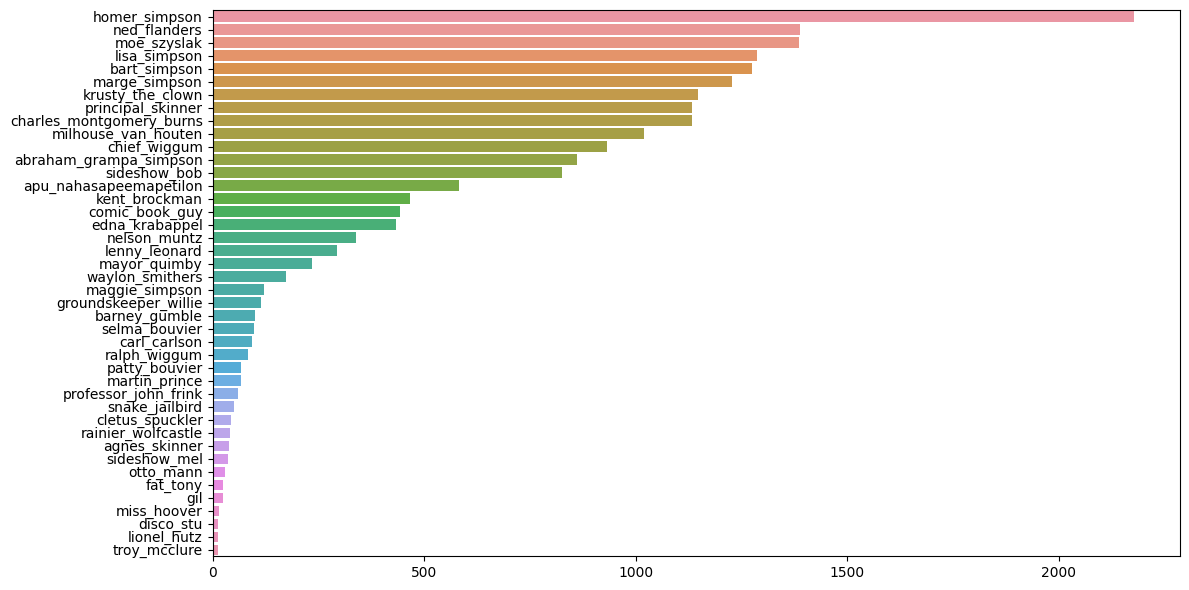

In [16]:
charnums = plot_character_distribution(train_val_labels)

### Split train labels into train and val data with stratification

In [17]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
train_indices, val_indices = next(sss.split(train_val_files, train_val_labels))

train_files = [train_val_files[i] for i in train_indices]
val_files = [train_val_files[i] for i in val_indices]

In [18]:
#train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)
train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]

In [19]:
unique_train_labels = set(train_labels)
unique_val_labels = set(val_labels)

if unique_train_labels == unique_val_labels:
    print("Every class is represented in both training and validation sets.")
else:
    print("Not every class is represented in both sets.")
    print(unique_train_labels-unique_val_labels)

Every class is represented in both training and validation sets.


## Load images as Datasets

In [20]:
class CFG:
  rescale_image = 224
  trans_max = 300
  imagenet_means = [0.485, 0.456, 0.406]
  imagenet_stds = [0.229, 0.224, 0.225]
  batchsize = 128
  lr = 1e-4
  device = lambda: 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = np.array(CFG.imagenet_stds) * inp.numpy().transpose(
                                      (1, 2, 0)) + np.array(CFG.imagenet_means)
    inp = np.clip(inp, 0, 1)

    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [22]:
class CustomDataset(Dataset):
  def __init__(self, files, train=True):
    super().__init__()
    self.files = sorted(files)
    self.le = LabelEncoder()
    self.train_mode = train
    if train:
      self.labels = self.l_encode

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    filename = self.files[idx]
    img = self._load_sample(filename)
    img = self._get_augs(img) if self.train_mode else self._get_transforms(img)
    return self._get_xy(img, idx)


  @staticmethod
  def _load_sample(name):
    img = Image.open(name)

    img.load()
    #img = img.resize((CFG.rescale_image, CFG.rescale_image))
    if img.mode in ('L','P'):
      img = img.convert('RGB')
    return img

  @property
  def l_encode(self):
    labels = [path.parent.name for path in self.files]
    self.le.fit(labels)
    with open('le.pkl', 'wb') as f:
      pickle.dump(self.le, f)
    return labels


  def _get_xy(self, x, y_idx):
    if self.train_mode:
      label = self.labels[y_idx]
      label_id = self.le.transform([label])
      return x, label_id.item()
    else:
      return x


  @staticmethod
  def _get_augs(img):
    percentile = 25#CFG.rescale_image//5

    augs = transforms.RandomChoice([transforms.Compose(
                  [transforms.Resize(size=CFG.trans_max, max_size=CFG.trans_max+1),
                   transforms.CenterCrop(size=CFG.trans_max),
                   transforms.RandomCrop(250)]),
                transforms.RandomRotation(degrees=(-percentile, percentile)),
                transforms.RandomAutocontrast(),
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                transforms.RandomHorizontalFlip(p=1)])

    transform = transforms.Compose([augs,
                                    transforms.Resize(size=(CFG.rescale_image,
                                                            CFG.rescale_image),
                                                      antialias=True),
                                    transforms.Lambda(lambda x: np.array(
                                                    x, dtype='float32') / 255),
                                    transforms.ToTensor(),
                                    transforms.Normalize(CFG.imagenet_means,
                                                         CFG.imagenet_stds)])
    return transform(img)


  @staticmethod
  def _get_transforms(img):
    transform = transforms.Compose([transforms.Resize(size=(CFG.rescale_image,
                                                            CFG.rescale_image),
                                                      antialias=True),
                                    transforms.Lambda(lambda x: np.array(
                                                      x, dtype='float32') / 255),
                                    transforms.ToTensor(),
                                    transforms.Normalize(CFG.imagenet_means,
                                                         CFG.imagenet_stds)])
    return transform(img)


### Set two kinds of data - for train: train and val and for test: trainval and test

In [23]:
train_dataset = CustomDataset(train_files)
val_dataset = CustomDataset(val_files)

trainval_dataset = CustomDataset(train_val_files)
test_dataset = CustomDataset(test_files, False)


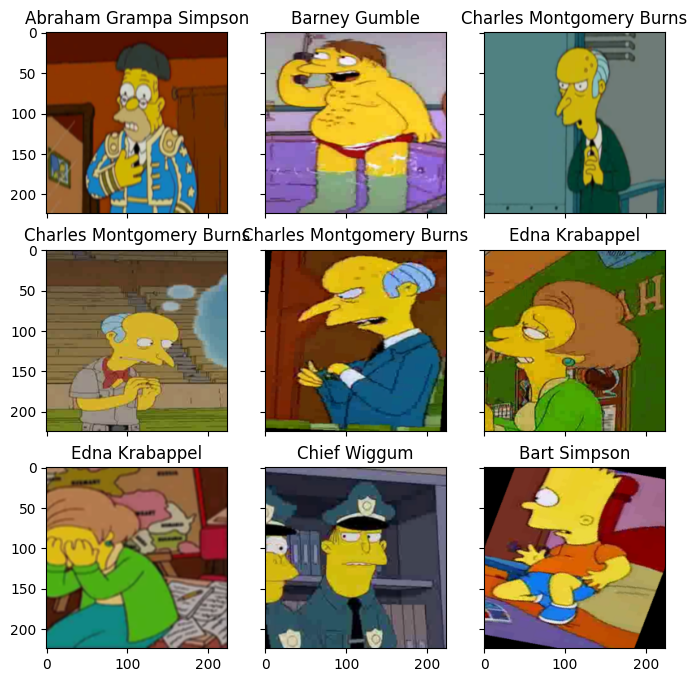

In [24]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.le.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Using random weighted sampler

kudos to [wervlad](https://www.kaggle.com/code/wervlad/baseline-2fc-augmentations) [vladislavzenin](https://www.kaggle.com/code/vladislavzenin/weightedrandomsampler) and [ndyarrrr](https://www.kaggle.com/code/ndyarrrr/1-0-score-with-baseline-model-3fc) for the WeightedRandomSampler

#### vladislavzenin and wervlad's approach

In [20]:
#weights_count = {k: 1/v for k,v in charnums.items()}
#weights_samples = [weights_count[label] for label in train_val_labels]
#N_vw = charnums.max() * len(weights_count)

#train_sampler_1 = WeightedRandomSampler(weights_samples, num_samples=int(N_vw), replacement=True)
#train_loader_1 = DataLoader(trainval_dataset, batch_size=CFG.batchsize, sampler=train_sampler_1, num_workers=2)

#### ndyarrrr's approach

In [21]:
#count_weights = {key: 1/value for key, value in charnums.items()}
#sample_weights = len(train_val_files) * [0]

#for i, (data, label) in enumerate(tqdm(trainval_dataset)):
#    label_weight = count_weights[trainval_dataset.le.inverse_transform([label])[0]]
#    sample_weights[i] = label_weight

In [22]:
#N_n = charnums.max() * len(count_weights)
#print(N_n)
#train_sampler_2 = WeightedRandomSampler(sample_weights, num_samples=int(N_n), replacement=True)
#train_dataloader_2 = DataLoader(trainval_dataset, batch_size=CFG.batchsize*2, sampler=train_sampler_2) #one worker twice tha batchsize

#### compare dicts in two approaches

In [23]:
#weights_count == count_weights

We are going to utilize all of this in the final part of learning when we train on train+val dataset but lets have a useful func instead of creating one instance in a cell

In [25]:
def weighted_dataloader_1(datasetfiles):
  labels = [path.parent.name for path in datasetfiles]
  counts = pd.Series(labels).value_counts()
  weights_count = {key: 1/val for key, val in counts.items()}
  weights_samples = [weights_count[label] for label in labels]
  N_vw = counts.max() * len(weights_count)
  sampler = WeightedRandomSampler(weights_samples, num_samples=int(N_vw), replacement=True)

  dataset = CustomDataset(datasetfiles)
  loader = DataLoader(dataset, batch_size=CFG.batchsize, sampler=sampler, num_workers=2)
  return loader

In [26]:
def weighted_dataloader_2(datasetfiles):
  labels = [path.parent.name for path in datasetfiles]
  counts = pd.Series(labels).value_counts()
  count_weights = {key: 1/value for key, value in counts.items()}
  sample_weights = len(datasetfiles) * [0]

  dataset = CustomDataset(datasetfiles)

  for i, (data, label) in enumerate(tqdm(dataset)):
      label_weight = count_weights[dataset.le.inverse_transform([label])[0]]
      sample_weights[i] = label_weight

  N_n = counts.max() * len(count_weights)
  sampler = WeightedRandomSampler(sample_weights, num_samples=int(N_n),
                                        replacement=True)

  loader = DataLoader(dataset, batch_size=CFG.batchsize,
                                sampler=sampler, num_workers=2)
  return loader

In [26]:
train_ds = weighted_dataloader_1(train_files)
val_ds = weighted_dataloader_1(val_files)

## Set up wandb

In [27]:
wandb_config = {
    'achitecture':'CNN',
    'CNN_layers': '5_3x3',
    'FC_layers':'3_2400_4800',
    'activation':'relu',
    'optimizer':'AdamW',
    'lr':CFG.lr,
    'lr_scheduler_step': 5,
    'batch_size':CFG.batchsize,
    'device':CFG.device(),
    'dropouts':0.2,
    'batchnorm':True
}

In [28]:
WANDBAPI = False
try:
  with open('wandb_api.txt', 'r') as f:
    WANDBAPI = f.readline()
    project="TVshow_characters_classification"
    entity='dimildizio'
    wandb.login(key=WANDBAPI)

except Exception as e:
  print(e)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [29]:
def wandb_wrapper(func):
    def wrapped_function(*args, **kwargs):
        if WANDBAPI:
            wandb.init(project=project,entity=entity, config=wandb_config)

        result = func(*args, **kwargs)
        if WANDBAPI:
            wandb.finish()
        return result
    return wrapped_function

## Write a simple CNN model

### Fit epoch function

In [30]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    print(CFG.device())
    for inputs, labels in train_loader:

        inputs = inputs.to(CFG.device())
        labels = labels.to(CFG.device())
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        print('batch loss:', running_loss/processed_data, \
              'acc:', running_corrects.cpu().numpy()/processed_data)


    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    scheduler.step()
    return train_loss, train_acc

### Eval epoch func

In [31]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(CFG.device())
        labels = labels.to(CFG.device())

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

### Whole training cycle

In [32]:
@wandb_wrapper
def train(train_files, val_dataset, model, epochs, batch_size):
    # we augment train dataset. it will take longer to learn
    #train_loader = DataLoader(train_dataset, batch_size=batch_size)#
    train_loader = weighted_dataloader_1(train_files)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # we dont do weighted on val

    print(train_loader, val_loader)
    best_val_loss = float('inf')
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=True)
        scheduler = lr_scheduler.StepLR(opt, step_size=4, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss:", train_loss, 'acc:', train_acc)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            if WANDBAPI:
              wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc,
                    "Val Loss": val_loss, "Val Accuracy": val_acc})

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            if val_loss < best_val_loss:
              best_val_loss = val_loss
              torch.save(model.state_dict(), 'best_model.pt')

    return history

### predict func

In [33]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(CFG.device())
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Training process

#### get layers size

In [34]:
def get_layer_size(insize, ouch, kernel=3, pool=2, pad=0, stride=1):
  size = int(((insize - kernel + 2 * pad) / stride + 1) // pool)
  print(f'layer_size: {size}x{size}x{ouch} = {size*size*ouch}')
  return size

def get_total_layer_size(size, ouch):
  total = size*size*ouch
  print('total fed into FC:', total)
  return total

In [114]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        s = get_layer_size(CFG.rescale_image, 8)

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        s = get_layer_size(s, 16)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        s = get_layer_size(s, 32)

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        s = get_layer_size(s, 64)


        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        s = get_layer_size(s, 96)

        total_layers = get_total_layer_size(s, 96)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        #self.fc = nn.Linear(total_layers, n_classes)
        self.fc1 = nn.Linear(total_layers, 4800)
        self.fc2 = nn.Linear(4800, 4800)
        self.fc3 = nn.Linear(4800, n_classes)

        for m in self.modules():
          if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
              nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Create model instance

In [115]:
n_classes = len(np.unique(train_labels))
simple_cnn = SimpleCnn(n_classes).to(CFG.device())
print("we will classify :{}".format(n_classes))
print(simple_cnn)

layer_size: 111x111x8 = 98568
layer_size: 54x54x16 = 46656
layer_size: 26x26x32 = 21632
layer_size: 12x12x64 = 9216
layer_size: 5x5x96 = 2400
total fed into FC: 2400
we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), st

### Train

In [37]:
#WANDBAPI = False

In [ ]:
history = train(train_files, val_files, model=simple_cnn, epochs=10, batch_size=CFG.batchsize)

<torch.utils.data.dataloader.DataLoader object at 0x7912e13d4820> <torch.utils.data.dataloader.DataLoader object at 0x7912e145cf10>


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

cuda
batch loss: 3.902853012084961 acc: 0.015625
batch loss: 3.785449504852295 acc: 0.04296875
batch loss: 3.6457484563191733 acc: 0.052083333333333336
batch loss: 3.607539117336273 acc: 0.056640625
batch loss: 3.5125545978546144 acc: 0.071875
batch loss: 3.4607640504837036 acc: 0.07942708333333333
batch loss: 3.4601067134312222 acc: 0.08370535714285714
batch loss: 3.399529457092285 acc: 0.0888671875
batch loss: 3.372097545199924 acc: 0.09375
batch loss: 3.368548846244812 acc: 0.096875
batch loss: 3.3664969097484243 acc: 0.1015625
batch loss: 3.336389124393463 acc: 0.10416666666666667
batch loss: 3.314706123792208 acc: 0.10336538461538461
batch loss: 3.310411810874939 acc: 0.1015625
batch loss: 3.2862489859263104 acc: 0.10572916666666667
batch loss: 3.2689996510744095 acc: 0.10595703125
batch loss: 3.2541280213524315 acc: 0.10753676470588236
batch loss: 3.230838325288561 acc: 0.11284722222222222
batch loss: 3.2106583243922184 acc: 0.11636513157894737
batch loss: 3.1918686509132383 acc:

epoch:  10%|█         | 1/10 [08:10<1:13:37, 490.84s/it]


Epoch 001 train_loss: 1.8293     val_loss 1.6687 train_acc 0.4959 val_acc 0.5480
cuda
batch loss: 1.2329148054122925 acc: 0.703125
batch loss: 1.1149190068244934 acc: 0.7265625
batch loss: 1.1833742062250774 acc: 0.6979166666666666
batch loss: 1.1789019405841827 acc: 0.70703125
batch loss: 1.1847012758255004 acc: 0.690625
batch loss: 1.2232166330019634 acc: 0.6731770833333334
batch loss: 1.2235227993556432 acc: 0.6685267857142857
batch loss: 1.2094748616218567 acc: 0.6787109375
batch loss: 1.2055724064509075 acc: 0.6744791666666666
batch loss: 1.2251435399055481 acc: 0.66484375
batch loss: 1.2289421991868452 acc: 0.6626420454545454
batch loss: 1.2150719165802002 acc: 0.6692708333333334
batch loss: 1.2098067907186656 acc: 0.6724759615384616
batch loss: 1.2028357642037528 acc: 0.6741071428571429
batch loss: 1.1964873552322388 acc: 0.6755208333333333
batch loss: 1.1873770877718925 acc: 0.6796875
batch loss: 1.1938066903282614 acc: 0.6760110294117647
batch loss: 1.189056071970198 acc: 0.6

epoch:  20%|██        | 2/10 [16:16<1:05:04, 488.05s/it]


Epoch 002 train_loss: 0.8999     val_loss 1.3696 train_acc 0.7567 val_acc 0.6406
cuda
batch loss: 0.7069314122200012 acc: 0.7734375
batch loss: 0.6760312914848328 acc: 0.8046875
batch loss: 0.6760890483856201 acc: 0.8072916666666666
batch loss: 0.701728567481041 acc: 0.810546875
batch loss: 0.6945186376571655 acc: 0.8125
batch loss: 0.6902426282564799 acc: 0.8111979166666666
batch loss: 0.6686726723398481 acc: 0.8180803571428571
batch loss: 0.6790357083082199 acc: 0.818359375
batch loss: 0.6916033029556274 acc: 0.8159722222222222
batch loss: 0.7135913252830506 acc: 0.81171875
batch loss: 0.7126712203025818 acc: 0.8125
batch loss: 0.7164501597483953 acc: 0.80859375
batch loss: 0.7111765742301941 acc: 0.8131009615384616
batch loss: 0.7088360829012734 acc: 0.8119419642857143
batch loss: 0.7259689291318258 acc: 0.8067708333333333
batch loss: 0.7329139411449432 acc: 0.80419921875
batch loss: 0.7208619117736816 acc: 0.8060661764705882
batch loss: 0.7340114580260383 acc: 0.8003472222222222
b

epoch:  30%|███       | 3/10 [24:21<56:45, 486.47s/it]


Epoch 003 train_loss: 0.6191     val_loss 1.2706 train_acc 0.8351 val_acc 0.6597
cuda
batch loss: 0.4447351098060608 acc: 0.859375
batch loss: 0.5489263236522675 acc: 0.84375
batch loss: 0.5433398683865865 acc: 0.8385416666666666
batch loss: 0.5188510417938232 acc: 0.849609375
batch loss: 0.48943266868591306 acc: 0.8578125
batch loss: 0.5057899157206217 acc: 0.85546875
batch loss: 0.5228165473256793 acc: 0.8470982142857143
batch loss: 0.5117561556398869 acc: 0.8486328125
batch loss: 0.5093852678934733 acc: 0.8506944444444444
batch loss: 0.5088694930076599 acc: 0.85390625
batch loss: 0.5254368727857416 acc: 0.8536931818181818
batch loss: 0.5137081816792488 acc: 0.857421875
batch loss: 0.5116048799111292 acc: 0.8581730769230769
batch loss: 0.5115971203361239 acc: 0.8604910714285714
batch loss: 0.5137891193230947 acc: 0.8588541666666667
batch loss: 0.5201162751764059 acc: 0.85693359375
batch loss: 0.5306021343259251 acc: 0.8543198529411765
batch loss: 0.5306816349426905 acc: 0.8528645833

epoch:  40%|████      | 4/10 [32:28<48:40, 486.78s/it]


Epoch 004 train_loss: 0.4707     val_loss 1.1927 train_acc 0.8747 val_acc 0.6767
cuda
batch loss: 0.41264286637306213 acc: 0.8828125
batch loss: 0.37093617022037506 acc: 0.8828125
batch loss: 0.43333885073661804 acc: 0.8723958333333334
batch loss: 0.4491412043571472 acc: 0.875
batch loss: 0.4397771120071411 acc: 0.8765625
batch loss: 0.4351453979810079 acc: 0.8763020833333334
batch loss: 0.4478510873658316 acc: 0.8761160714285714
batch loss: 0.4386856369674206 acc: 0.8779296875
batch loss: 0.4414147999551561 acc: 0.8793402777777778
batch loss: 0.4513833045959473 acc: 0.878125
batch loss: 0.44910394061695447 acc: 0.8778409090909091
batch loss: 0.4478846142689387 acc: 0.876953125
batch loss: 0.44482054847937363 acc: 0.8798076923076923
batch loss: 0.45484131787504467 acc: 0.8783482142857143
batch loss: 0.45270551443099977 acc: 0.8786458333333333
batch loss: 0.45294006913900375 acc: 0.8779296875
batch loss: 0.46302734753664804 acc: 0.8759191176470589
batch loss: 0.4567946030033959 acc: 0.

epoch:  50%|█████     | 5/10 [40:39<40:41, 488.37s/it]


Epoch 005 train_loss: 0.3767     val_loss 1.1512 train_acc 0.9001 val_acc 0.6992
cuda
batch loss: 0.3964083194732666 acc: 0.8984375
batch loss: 0.3949792683124542 acc: 0.90234375
batch loss: 0.44285305341084796 acc: 0.8958333333333334
batch loss: 0.42716124653816223 acc: 0.90234375
batch loss: 0.40903499722480774 acc: 0.9078125
batch loss: 0.38230473299821216 acc: 0.9088541666666666
batch loss: 0.36130080265658243 acc: 0.9118303571428571
batch loss: 0.35094547085464 acc: 0.912109375
batch loss: 0.35070131719112396 acc: 0.9097222222222222
batch loss: 0.3427106663584709 acc: 0.909375
batch loss: 0.3369056297974153 acc: 0.9112215909090909
batch loss: 0.34233390912413597 acc: 0.91015625
batch loss: 0.3366744231719237 acc: 0.9098557692307693
batch loss: 0.34360922979457037 acc: 0.9084821428571429
batch loss: 0.3463282436132431 acc: 0.9083333333333333
batch loss: 0.35109776351600885 acc: 0.908203125
batch loss: 0.35119154085131254 acc: 0.9080882352941176
batch loss: 0.3423798754811287 acc: 

epoch:  60%|██████    | 6/10 [48:50<32:36, 489.21s/it]


Epoch 006 train_loss: 0.2851     val_loss 0.9847 train_acc 0.9245 val_acc 0.7372
cuda
batch loss: 0.2064673900604248 acc: 0.9609375
batch loss: 0.23126840591430664 acc: 0.9453125
batch loss: 0.21297024687131247 acc: 0.9479166666666666
batch loss: 0.24406658858060837 acc: 0.931640625
batch loss: 0.22398348450660704 acc: 0.9421875
batch loss: 0.2397982676823934 acc: 0.9375
batch loss: 0.22791012057236262 acc: 0.9397321428571429
batch loss: 0.21974351815879345 acc: 0.9423828125
batch loss: 0.22811902397208744 acc: 0.9418402777777778
batch loss: 0.23194945305585862 acc: 0.9421875
batch loss: 0.23705311661416834 acc: 0.9424715909090909
batch loss: 0.23748218764861426 acc: 0.94140625
batch loss: 0.23653608445937818 acc: 0.9405048076923077
batch loss: 0.23883593827486038 acc: 0.9391741071428571
batch loss: 0.24344010651111603 acc: 0.9369791666666667
batch loss: 0.24985058140009642 acc: 0.935546875
batch loss: 0.2603343523600522 acc: 0.9329044117647058
batch loss: 0.25738372653722763 acc: 0.9

epoch:  70%|███████   | 7/10 [56:55<24:22, 487.58s/it]


Epoch 007 train_loss: 0.2616     val_loss 0.9848 train_acc 0.9317 val_acc 0.7508
cuda
batch loss: 0.20782844722270966 acc: 0.9375
batch loss: 0.21972454339265823 acc: 0.94140625
batch loss: 0.19292589028676352 acc: 0.9479166666666666
batch loss: 0.21716035902500153 acc: 0.9453125
batch loss: 0.252229118347168 acc: 0.934375
batch loss: 0.26563310126463574 acc: 0.93359375
batch loss: 0.25342257959502085 acc: 0.9330357142857143
batch loss: 0.24909957312047482 acc: 0.9296875
batch loss: 0.2544914235671361 acc: 0.9305555555555556
batch loss: 0.2580737009644508 acc: 0.92890625
batch loss: 0.2509812360460108 acc: 0.9311079545454546
batch loss: 0.25956502308448154 acc: 0.9296875
batch loss: 0.25301363376470715 acc: 0.9308894230769231
batch loss: 0.2483435454113143 acc: 0.9330357142857143
batch loss: 0.2488321175177892 acc: 0.9333333333333333
batch loss: 0.24333501793444157 acc: 0.93505859375
batch loss: 0.2424210835905636 acc: 0.9352022058823529
batch loss: 0.25638654331366223 acc: 0.93185763

### Final train for the whole train+val dataset. can be used as transfer learning by simply passing the same model

In [35]:
@wandb_wrapper
def train_for_submission(train_loader, model, epochs):
    train_loader = weighted_dataloader_1(train_loader)

    history = []

    log_template = 'Epoch - {ep: 03d}, train loss: {tr_loss: 0.4f}, train acc: {tr_acc: 0.4f}'

    with tqdm(desc='Epoch', total=epochs) as pbar:
        optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, amsgrad=True)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, scheduler)
            history.append((train_loss, train_acc))
            pbar.update(1)
            tqdm.write(log_template.format(ep=epoch+1, tr_loss = train_loss, tr_acc = train_acc))
            if WANDBAPI:
              wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc})
    return history

In [ ]:
history_for_submission = train(train_val_files, model=simple_cnn, epochs=10, batch_size=CFG.batchsize)

#### With augmentations and downloading files from internet the score might seem lower when in fact it's ~0.97662 with learning rate 4e-4

### Results

The architecture above shows that the result 0.976 on test dataset even though there are better solutions on simplier approach (5conv + 3fc, augs, weighted random sampler, scheduler and suboptimal learning rate)

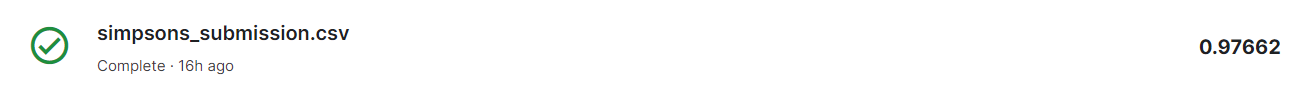

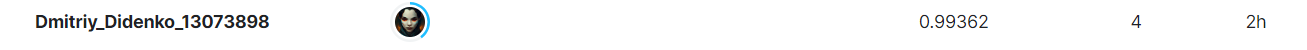

## Transfer learning

So for transfer learning we could continue training the model on trainval dataset (it this case it's more like Active learning on new data)

### Active learning

1. step 1: train the model on train and val datasets
2. step 2: train the same model on train_val dataset combined without evaluation

In [ ]:
cnn = SimpleCnn(n_classes).to(CFG.device())
history = train(train_files, val_files, model=cnn, epochs=10, batch_size=CFG.batchsize)
train_for_submission(train_val_files, cnn, 20)

#### We could also save the model (best model is saved anyway during training process) and load it later to train

In [36]:
def load_model(model_name='best_model.pt'):
  if os.path.isfile(model_name):
    print('Loading model')
    model = SimpleCnn(42)
    model.load_state_dict(torch.load(model_name))

In [37]:
def set_train_mode(model):
  model.train()
  optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, amsgrad=True)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
  return model, optimizer, scheduler


def inference(model, my_input):
  model.eval()
  with torch.no_grad():
    result = model(my_input)
  return result

#### We could go either way or alternativelly we could cut off the classification head of a larger model like ResNet

### Resnet

We can solve this problem in two ways:

1. We freeze convolution layers and retrain only fully connected
2. We retrain the whole model, all layers

Approach 1: Takes longer converge.

In [ ]:
resnet_model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

for name, param in resnet_model.named_parameters():
  if ('fc' not in name) or ('layer4.2' not in name):          #we retrain only fc layer and last conv layer
    param.requires_grad = False

resnet_model.fc = nn.Linear(2048, 42)
resnet_model.fc.requres_grad=True
resnet_model = resnet_model.to(CFG.device())
WANDBAPI=False
train_for_submission(train_val_files, resnet_model, 3)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

cpu
batch loss: 3.745659351348877 acc: 0.03125
batch loss: 3.752619981765747 acc: 0.03125
batch loss: 3.754587173461914 acc: 0.0234375
batch loss: 3.7532167434692383 acc: 0.0234375
batch loss: 3.7504226684570314 acc: 0.025
batch loss: 3.748683492342631 acc: 0.026041666666666668
batch loss: 3.74581207547869 acc: 0.03125
batch loss: 3.74326753616333 acc: 0.029296875
batch loss: 3.7437622812059193 acc: 0.029513888888888888
batch loss: 3.7418493270874023 acc: 0.03046875
batch loss: 3.7424532283436167 acc: 0.029829545454545456
batch loss: 3.7391889095306396 acc: 0.031901041666666664
batch loss: 3.737354278564453 acc: 0.03365384615384615
batch loss: 3.7366899251937866 acc: 0.03515625
batch loss: 3.735597244898478 acc: 0.0359375
batch loss: 3.7345459014177322 acc: 0.03564453125
batch loss: 3.732423151240629 acc: 0.03630514705882353
batch loss: 3.7317004998524985 acc: 0.03732638888888889
batch loss: 3.730567794097097 acc: 0.036595394736842105
batch loss: 3.728586494922638 acc: 0.039453125
batc

Approach 2: also takes long time but works faster

In [53]:
resnet_model = models.resnet50(weights="IMAGENET1K_V2")
# in this case we won't freeze any layers
resnet_model.fc = nn.Linear(2048, 42)
resnet_model = resnet_model.to(CFG.device())
train_for_submission(train_val_files, resnet_model, 10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

cuda
batch loss: 3.7431247234344482 acc: 0.03125
batch loss: 3.7434420585632324 acc: 0.0234375
batch loss: 3.72993532816569 acc: 0.033854166666666664
batch loss: 3.7246115803718567 acc: 0.0390625
batch loss: 3.7196652412414553 acc: 0.0484375
batch loss: 3.7140996853510537 acc: 0.057291666666666664
batch loss: 3.708068370819092 acc: 0.06584821428571429
batch loss: 3.704678386449814 acc: 0.0732421875
batch loss: 3.6985965834723578 acc: 0.07899305555555555
batch loss: 3.692758893966675 acc: 0.08359375
batch loss: 3.6861198165199975 acc: 0.09232954545454546
batch loss: 3.678032159805298 acc: 0.09830729166666667
batch loss: 3.667724994512705 acc: 0.10697115384615384
batch loss: 3.6598095382962907 acc: 0.11216517857142858
batch loss: 3.6498276869455974 acc: 0.1203125
batch loss: 3.6414396464824677 acc: 0.13037109375
batch loss: 3.632684483247645 acc: 0.13602941176470587
batch loss: 3.6253895494672985 acc: 0.140625
batch loss: 3.6169571249108565 acc: 0.1455592105263158
batch loss: 3.605798304

Epoch:  10%|█         | 1/10 [17:52<2:40:53, 1072.62s/it]

batch loss: 0.32515508157186734 acc: 0.9394158030521667
Epoch -  01, train loss:  0.3252, train acc:  0.9394
cuda
batch loss: 0.015623020008206367 acc: 1.0
batch loss: 0.009679916896857321 acc: 1.0
batch loss: 0.00884912139736116 acc: 1.0
batch loss: 0.00768937700195238 acc: 1.0
batch loss: 0.010220024129375815 acc: 0.9984375
batch loss: 0.011373327540544173 acc: 0.9986979166666666
batch loss: 0.015543508842321379 acc: 0.9977678571428571
batch loss: 0.01689889989211224 acc: 0.998046875
batch loss: 0.01866894595635434 acc: 0.9965277777777778
batch loss: 0.01995208121370524 acc: 0.9953125
batch loss: 0.020480759674683213 acc: 0.9950284090909091
batch loss: 0.01936475666783129 acc: 0.9954427083333334
batch loss: 0.02043271421168286 acc: 0.9951923076923077
batch loss: 0.01931848209018686 acc: 0.9955357142857143
batch loss: 0.018332226434722543 acc: 0.9958333333333333
batch loss: 0.018147274837247096 acc: 0.99560546875
batch loss: 0.017399604692507314 acc: 0.9958639705882353
batch loss: 0.0

Epoch:  20%|██        | 2/10 [35:34<2:22:10, 1066.32s/it]

batch loss: 0.013811914649026358 acc: 0.996775110411474
Epoch -  02, train loss:  0.0138, train acc:  0.9968
cuda
batch loss: 0.004481993615627289 acc: 1.0
batch loss: 0.0057139836717396975 acc: 1.0
batch loss: 0.008938141322384277 acc: 0.9973958333333334
batch loss: 0.007013649301370606 acc: 0.998046875
batch loss: 0.01104102476965636 acc: 0.996875
batch loss: 0.009641375838934133 acc: 0.9973958333333334
batch loss: 0.008584222972526081 acc: 0.9977678571428571
batch loss: 0.008109053669613786 acc: 0.998046875
batch loss: 0.007622466125111613 acc: 0.9982638888888888
batch loss: 0.009635418851394207 acc: 0.99765625
batch loss: 0.008924452704377472 acc: 0.9978693181818182
batch loss: 0.008979333826573566 acc: 0.9973958333333334
batch loss: 0.008670221038091067 acc: 0.9975961538461539
batch loss: 0.00891803766301434 acc: 0.9977678571428571
batch loss: 0.009232130856253207 acc: 0.9979166666666667
batch loss: 0.008752779292990454 acc: 0.998046875
batch loss: 0.009027897339204656 acc: 0.9981

Epoch:  30%|███       | 3/10 [53:20<2:04:23, 1066.19s/it]

Epoch -  03, train loss:  0.0076, train acc:  0.9983
cuda
batch loss: 0.0008740509510971606 acc: 1.0
batch loss: 0.01019257356529124 acc: 0.99609375
batch loss: 0.0069312027577931685 acc: 0.9973958333333334
batch loss: 0.015141281037358567 acc: 0.99609375
batch loss: 0.016497764526866375 acc: 0.9953125
batch loss: 0.01382309413262798 acc: 0.99609375
batch loss: 0.013148679111119626 acc: 0.9966517857142857
batch loss: 0.012785018636350287 acc: 0.9970703125
batch loss: 0.011780998420565285 acc: 0.9973958333333334
batch loss: 0.01081204682996031 acc: 0.99765625
batch loss: 0.009926756439116698 acc: 0.9978693181818182
batch loss: 0.010183916211341662 acc: 0.9973958333333334
batch loss: 0.010364389134338126 acc: 0.9975961538461539
batch loss: 0.009682529691157729 acc: 0.9977678571428571
batch loss: 0.00930287383380346 acc: 0.9979166666666667
batch loss: 0.010678597654987243 acc: 0.99755859375
batch loss: 0.01027577418512117 acc: 0.9977022058823529
batch loss: 0.010820286906285522 acc: 0.997

Epoch:  30%|███       | 3/10 [54:16<2:06:37, 1085.37s/it]


KeyboardInterrupt: ignored

3 epochs is enough for .998 train score. We could get a bit more but it takes forever to train even one epoch. Resnet is an overkill for this dataset after all

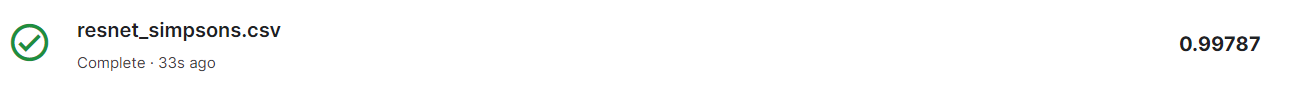

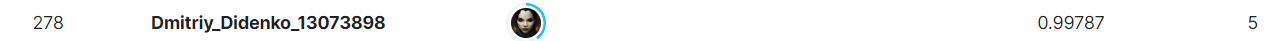

### And that's how we save the model

In [ ]:
torch.save(resnet_model.state_dict(), 'resnet.pt')

### visualize learning emmm curve

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Predict a sample

In [55]:
def predict_one_sample(model, inputs):
    with torch.no_grad():
        inputs = inputs.to(CFG.device())
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

### prodice and calculate f1-score

In [57]:
eval_dataset = CustomDataset(val_files)
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = eval_dataset[random_characters]
probs_im = predict_one_sample(resnet_model, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [eval_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(resnet_model, imgs)
label_encoder = pickle.load(open("le.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)

actual_labels = [eval_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-score:", f1)


F1-score: 1.0


### visualize confidence of the CCN. it sucks

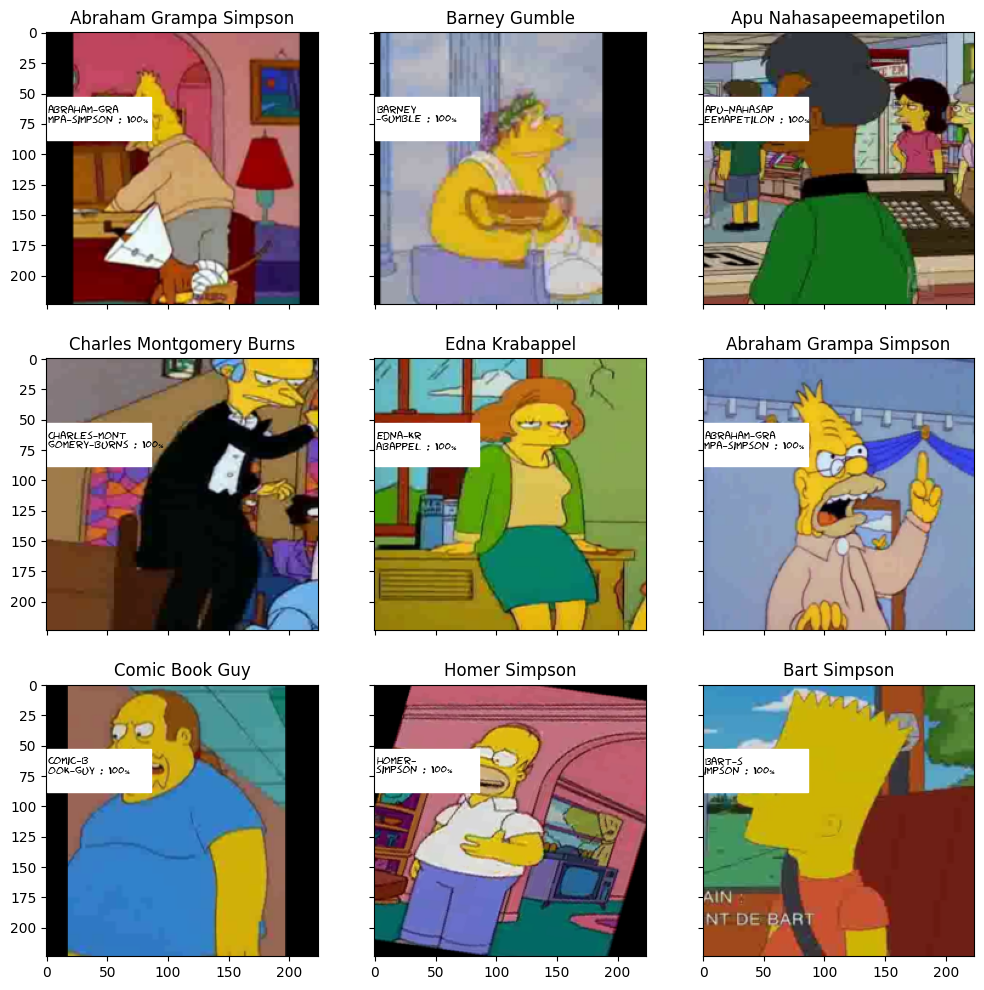

In [59]:

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.le.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(resnet_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [61]:
test_dataset = CustomDataset(test_files, train=False)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(resnet_model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()
my_submit.to_csv('simpsons_submission.csv', index=False)
files.download('simpsons_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Runs for accuracy and loss on training and evaluation could be seen [here at WandB](https://wandb.ai/dimildizio/TVshow_characters_classification?workspace=user-dimildizio)

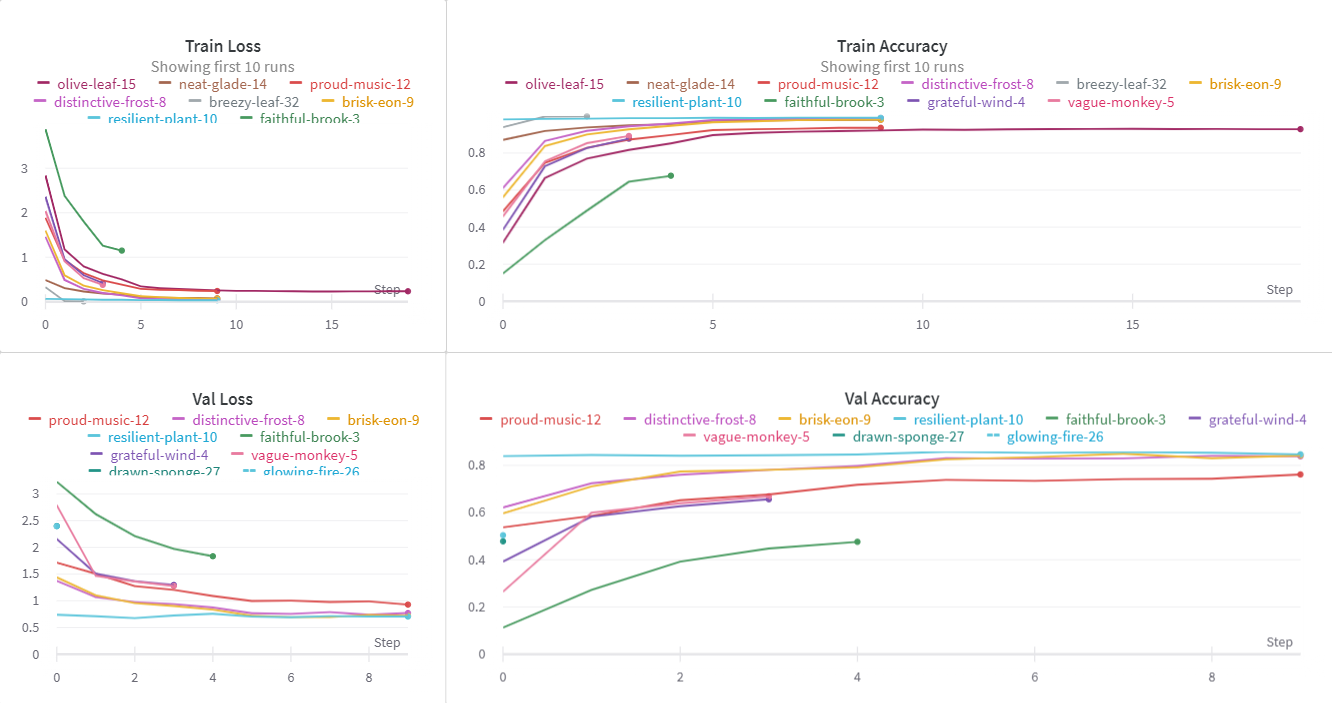

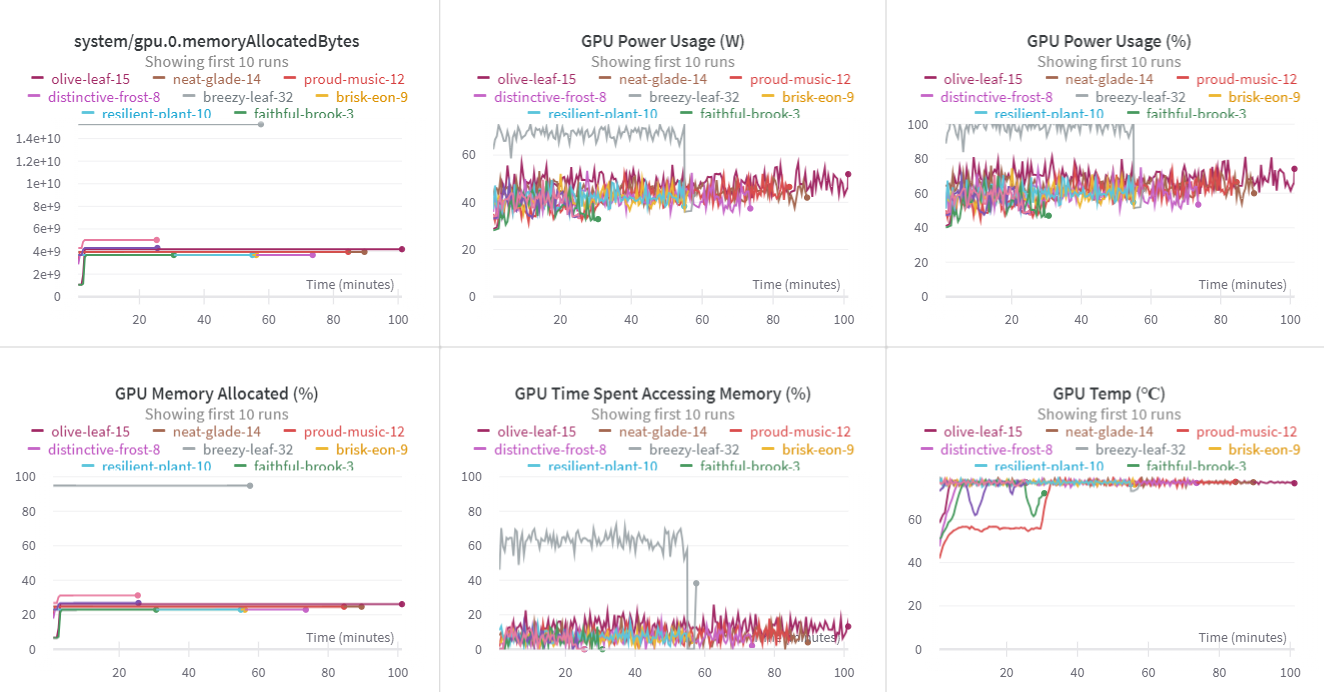

# Thank you for attention